## Mt. Rainier Daymet precipitation example
This example focuses on using the [xarray package](http://xarray.pydata.org/en/stable/why-xarray.html) to load and process a [NetCDF](https://www.unidata.ucar.edu/software/netcdf/) file of gridded precipitation data from the [Daymet model](https://daymet.ornl.gov/overview). Xarray aims to make working with multi-dimensional data easier, by implementing labeling of indices (e.g., to allow arrays to be indexed or sliced based on x and y coordinates or time, similar to what pandas does for tabular data).

<img src="http://xray.readthedocs.org/en/stable/_images/dataset-diagram.png" alt="Drawing" style="width: 600px;"/>


#### Datasets:
* Gridded precipitation output from the [Daymet model](https://daymet.ornl.gov/overview), for 1980-2018, for the area around Mt. Rainier.
* An elevation raster for the area around Mt. Rainier, created in the `gis_raster_mt_rainier_glaciers.ipynb` exercise.

#### Operations:
* make a `DataArray` from scratch (using the `DataArray()` constructor)
* load a NetCDF dataset into an `xarray.DataSet` instance
* plotting the NetCDF data in projected or geographic coordinates
* getting values at point locations
* coordinate transformations
* slicing in time and space
* boolean slicing
* computing monthly averages using `groupby`
* outputting extracted timeseries to pandas DataFrames
* subsetting the xarray dataset and saving to a NetCDF file

#### References:
* The [xarray manual](http://xarray.pydata.org/en/stable/why-xarray.html)
* The [GeoHackWeek tutorials](https://github.com/geohackweek/tutorial_contents/tree/master/nDarrays/notebooks)
* [this tutorial from Columbia University](https://rabernat.github.io/research_computing/xarray.html)

In [1]:
import pandas as pd
import rasterio
from rasterio.plot import show
import xarray as xr
from pyproj import Transformer
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource

# for elevation hillshade if we want to use it
ls = LightSource(azdeg=315, altdeg=45)

### DataArrays
The basic data structure in xarray is the DataArray, analogous to a Series in pandas. Data Arrays store data for a single variable, and can be any number of dimensions. Below is a simple example of a 1D DataArray.

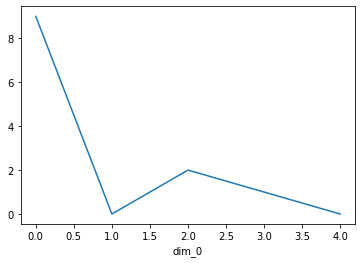

In [2]:
da = xr.DataArray([9, 0, 2, 1, 0])
da.plot()

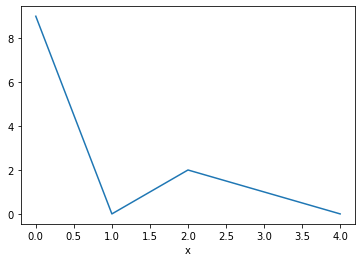

In [3]:
da = xr.DataArray([9, 0, 2, 1, 0], dims=['x'])
da.plot()

### Coordinates
The real power of Xarray is being able to specify coordinates for each data point (e.g. in x, y, z, time), and then index or slice the data using those coordinates, like in pandas

In [4]:
da = xr.DataArray([9, 0, 2, 1, 0],
                  dims=['x'],
                  coords={'x': [10, 20, 30, 40, 50]})
da

<xarray.DataArray (x: 5)>
array([9, 0, 2, 1, 0])
Coordinates:
  * x        (x) int64 10 20 30 40 50

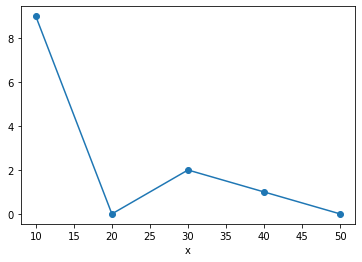

In [5]:
da.plot(marker='o')

In [6]:
da.loc[:20]

<xarray.DataArray (x: 2)>
array([9, 0])
Coordinates:
  * x        (x) int64 10 20

## Datasets
A Dataset holds multiple DataArrays, analogous to a DataFrame in pandas housing multiple Series. Like in Pandas, the different DataArrays can share coordinates.

### inputs
* [Daymet](https://daymet.ornl.gov/overview) gridded precipitation estimates for area around Mt. Rainier, 1980-2018. Obtained via the [Daymet Tile Selection Tool](https://daymet.ornl.gov/gridded/)
* a [proj string](https://proj.org/usage/quickstart.html) for Daymet could be created from the [dataset description](https://daymet.ornl.gov/overview); however, it was easier to just copy it from [here](http://rpubs.com/tbiggs/GEOG576_EX3_DAYMET)
* a 30 m DEM of elevations around Mt. Rainier, in geographic coordinates, created in the `gis_raster_mt_rainier_glaciers.ipynb` exercise

In [7]:
daymet_prcp_data = 'data/gis/daymet_prcp_rainier_1980-2018.nc'
daymet_proj_string = '+proj=lcc +lon_0=-100 +lat_0=42.5 +x_0=0 +y_0=0 +lat_1=25 +lat_2=60 +ellps=WGS84'
mt_rainier_elevations = 'data/gis/aligned-19700901_ned1_2003_adj_4269.tif'

### Load the Mt. Rainier precipitation dataset

**Note:** Datasets spanning multiple files can also be loaded using the [`xr.open_mfdataset()`](http://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html) constructor (requires the [Dask](https://dask.org/) package). The beauty of xarray's load methods is that they are [lazy](https://en.wikipedia.org/wiki/Lazy_loading), meaning the dataset is scanned to gain an understanding of its contents, but the actual data isn't loaded into memory until it is actually needed. This allows one to work on very large (10s or 100s of GB) datasets that wouldn't fit into memory.

In [8]:
ds = xr.load_dataset(daymet_prcp_data)

In [9]:
ds

<xarray.Dataset>
Dimensions:                  (nv: 2, time: 14235, x: 30, y: 31)
Coordinates:
    lat                      (y, x) float64 46.96 46.97 46.97 ... 46.76 46.76
    lon                      (y, x) float64 -122.0 -122.0 ... -121.5 -121.5
  * x                        (x) float64 -1.581e+06 -1.58e+06 ... -1.552e+06
  * y                        (y) float64 6.83e+05 6.82e+05 ... 6.54e+05 6.53e+05
  * time                     (time) datetime64[ns] 1980-01-01T12:00:00 ... 2018-12-31T12:00:00
Dimensions without coordinates: nv
Data variables:
    lambert_conformal_conic  (time) int16 -32767 -32767 -32767 ... -32767 -32767
    yearday                  (time) int16 0 1 2 3 4 5 ... 360 361 362 363 364
    prcp                     (time, y, x) float32 nan 15.0 15.0 ... 0.0 0.0 0.0
    time_bnds                (time, nv) datetime64[ns] 1980-01-01 ... 2019-01-01
Attributes:
    tileid:            12270
    start_year:        1980
    source:            Daymet Software Version 3.0
    Vers

#### make a quick plot of the mean precipitation through time (1980-2018) at each pixel (data point)

/Users/aleaf/anaconda3/envs/pyclass/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


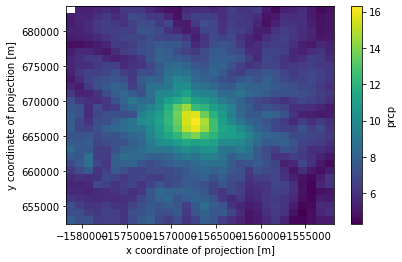

In [10]:
ds.prcp.mean(dim='time').plot()

### what if we want to plot the data in geographic coordinates?
we can use the attached `DataArray.plot.pcolormesh` method, which wraps `pyplot.pcolormesh`. `pcolormesh` takes grids of x and y values corresponding to each position in the array to be plotted. The attached xarray method just requires us to specify the label indices with the x and y values.

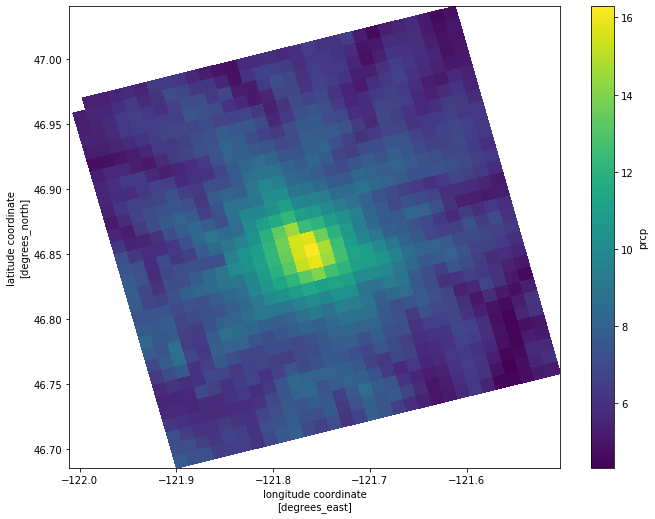

In [11]:
fig, ax = plt.subplots(figsize=(11, 8.5))
qm = ds.prcp.mean(dim='time').plot.pcolormesh('lon', 'lat', rasterized=True)

### Let's add some topography for reference

Load the elevation data with `rasterio`, get the bounding extent, and `rasterio.show` to quickly plot the data with its coordinates (instead of row, column locations)

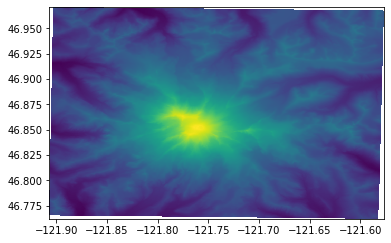

In [12]:
with rasterio.open(mt_rainier_elevations) as src:
    elev_bounds = src.bounds
    # reorder the rasterio bounds for pyplot
    elev_extent = (elev_bounds[0], elev_bounds[2], 
                   elev_bounds[1], elev_bounds[3])
    elevations = src.read(1)
    show(src)

### Overlay the mean precip. values on the topography
* use the `matplotlib` `LightSource.hillshade` method to convert the elevations to a shaded relief raster
    * assign `zorder=-1` to ensure that the data plot on the bottom
* plot mean precip, but specify `alpha < 1` so that it has some transparency; the colorbar can be controlled with `cbar_kwargs` (arguments that are passed to the `matplotlib` colorbar constructor)
* set the plot limits to the extent of the elevation raster (`*` unpacks list elevations into individual arguments)

(-121.90692427970136, -121.57658593832636)

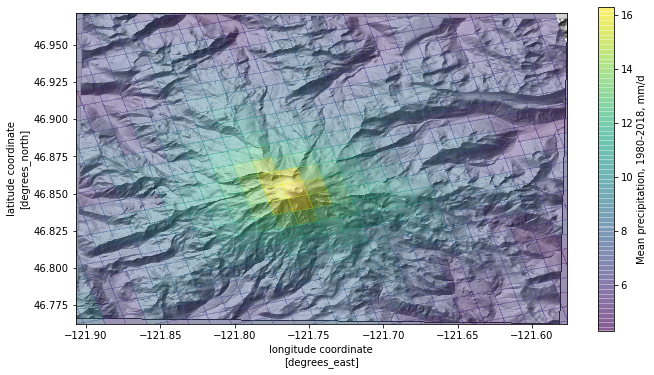

In [13]:
fig, ax = plt.subplots(figsize=(11, 8.5))
ax.imshow(ls.hillshade(elevations, vert_exag=0.1), cmap='gray', extent=elev_extent, 
          zorder=-1)
qm = ds.prcp.mean(dim='time').plot.pcolormesh('lon', 'lat', rasterized=True, #linewidth=0, 
                                              alpha=0.4, cbar_kwargs={'shrink': 0.7,
                                                                      'label': 'Mean precipitation, 1980-2018, mm/d'})
ax.set_ylim(*elev_extent[2:])
ax.set_xlim(*elev_extent[:2])

## Getting data at point locations

Say we want to get data for the mountain summit, and at the Paradise Visitor Center in Mt. Rainier National Park.
We can easily get the lat, lon coordinates for these locations, but to get data from this dataset, we need to work in the [custom coordinate system for Daymet](https://daymet.ornl.gov/overview). Luckly, we found a PROJ string to define that, which we assigned to the variable `daymet_proj_string`. With the PROJ string, we can use `pyproj` to transform the coordinates to the Daymet CRS.

In [14]:
coords = {'summit': (46.852886, -121.760374),
          'paradise': (46.7868, -121.7338)}

transformer = Transformer.from_crs(4269, daymet_proj_string)
coords_lcc = {k: transformer.transform(*v) for k, v in coords.items()}
coords_lcc

{'summit': (-1567320.5383531053, 667030.7252830399),
 'paradise': (-1567257.8370503802, 659751.1451685634)}

#### plot the two locations

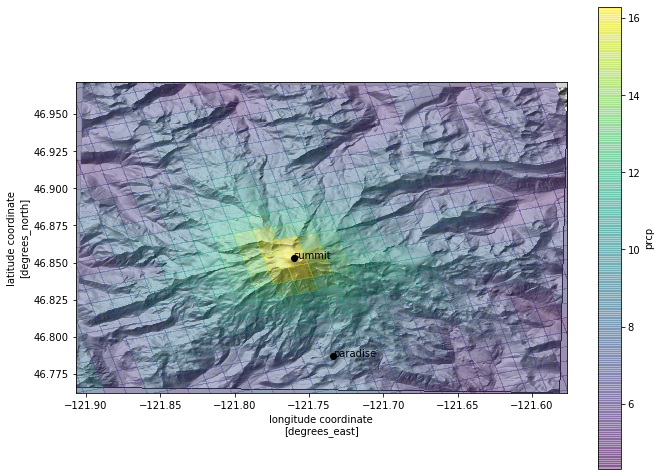

In [15]:
fig, ax = plt.subplots(figsize=(11, 8.5))
ax.imshow(ls.hillshade(elevations, vert_exag=0.1), cmap='gray', extent=elev_extent, 
          zorder=-1)
qm = ds.prcp.mean(dim='time').plot.pcolormesh('lon', 'lat', rasterized=True, #linewidth=0, 
                                              alpha=0.4)
ax.set_ylim(*elev_extent[2:])
ax.set_xlim(*elev_extent[:2])
for label, (y, x) in coords.items():
    ax.scatter(x, y, c='k')
    ax.text(x, y, label, transform=ax.transData)

### Get a time series of precip values at the nearest pixel to the summit

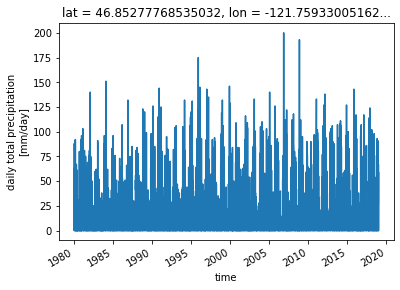

In [16]:
x, y = coords_lcc['summit']
ds.prcp.sel(x=[x], y=[y], method='nearest').plot()

### we can also slice along the time axis
But to do that, we need to chain the operation (instead of including the `time=` argument in the first call to `DataArray.sel()`)

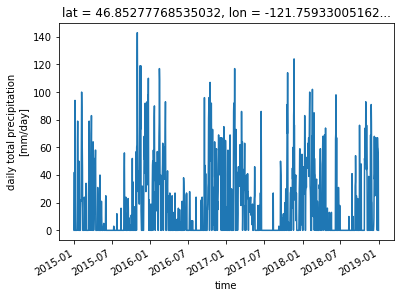

In [17]:
ds.prcp.sel(x=[x], y=[y], method='nearest').sel(time=slice('2015', '2018')).plot()

### slicing the whole dataset in time

Taking getting the mean value for 2012 (note, we could also simply write `time=slice('2012')`

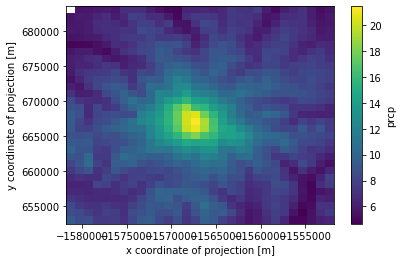

In [18]:
ds.prcp.sel(time=slice('2012-01-01', '2012-12-31')).mean(axis=0).plot()

### making a 2D slice spatially

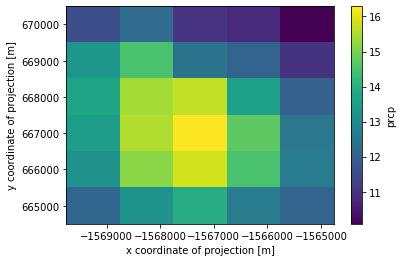

In [19]:
ds.prcp.sel(x=slice(-1570000, -1565000), y=slice(670000, 665000)).mean(axis=0).plot()

### what if we want to slice by latitude and longitude
The projected coordinate system that this dataset is aligned with is not aligned with latitude and longitude, so the lat and lon coordinates associated with each pixel are 2D.

In [20]:
ds.lat.shape

(31, 30)

### boolean slicing
In other words, a box aligned with latitude and longitude will be rotated in the native CRS. Therefore we have to either specify explicitly what lat, lon values we want, or we can use a boolean slice. Let's say we want all of the pixels between 46.8 and 46.9 N, and -121.8 and -121.7 longitude.

In [21]:
valid_lat = (ds['lat'].values > 46.8) & (ds['lat'].values < 46.9)
valid_lon = (ds['lon'].values > -121.8) & (ds['lon'].values < -121.7)

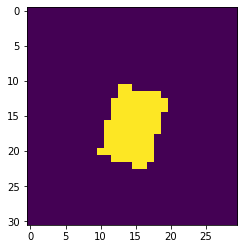

In [22]:
plt.imshow(valid_lat&valid_lon)

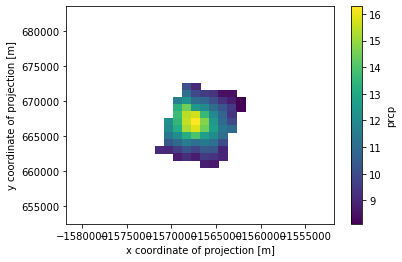

In [23]:
ds.prcp.loc[:].where(valid_lat&valid_lon).mean(axis=0).plot()

### Writing out subsetted data to new netcdf file
The above boolean indexing only masks the pixels that evaluated to `False`. Oftentimes, we want to subset a large dataset to only include the area we are working in.

#### drop the rows and columns that have all nans

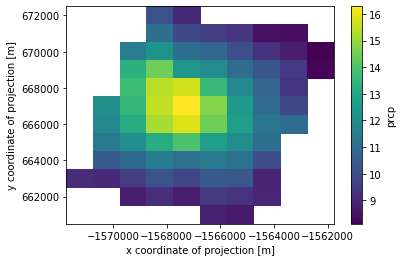

In [24]:
prcp_subset = ds.prcp.loc[:].where(valid_lat&valid_lon)
prcp_subset = prcp_subset.dropna(dim='x', how='all').dropna(dim='y', how='all')
prcp_subset.mean(axis=0).plot()

#### write it out to a netcdf file

In [25]:
prcp_subset.to_netcdf('data/gis/rainier_prcp_subset.nc')

## Groupby
more in [the xarray manual](http://xarray.pydata.org/en/stable/groupby.html)

#### getting monthly values

In [26]:
ds.prcp.groupby('time.month').mean(dim='time').shape

/Users/aleaf/anaconda3/envs/pyclass/lib/python3.7/site-packages/xarray/core/common.py:657: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims


(12, 31, 30)

### monthy mean precipitation for the whole dataset, in mm/day

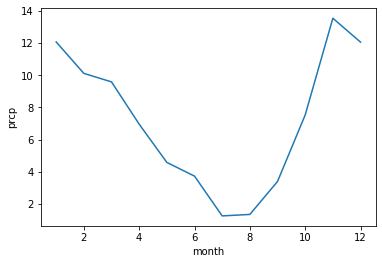

In [27]:
ds.prcp.groupby('time.month').mean(dim='time').mean(axis=(1, 2)).plot()

### comparing precip at the summit vs. Paradise

In [28]:
coords_lcc

{'summit': (-1567320.5383531053, 667030.7252830399),
 'paradise': (-1567257.8370503802, 659751.1451685634)}

#### convert to feet per month
by multipling by 30.4, the average number of days in a month. This is just for the sake of simplicity in this exercise. A better way to do this would be to multiply by an array with the number of days in each month.

In [29]:
prcp_monthly_mean_ft = ds.prcp.groupby('time.month').mean(dim='time') * (30.4/304.8)

#### Note that in the winter, these values represent snow-water equivalent, not snowfall

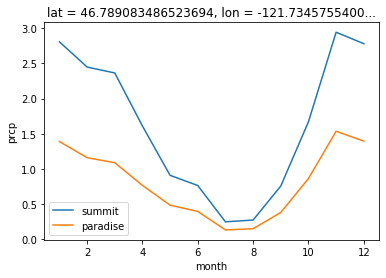

In [30]:
fig, ax = plt.subplots()
for site in ['summit', 'paradise']:
    prcp_site = prcp_monthly_mean_ft.sel(x=coords_lcc[site][0], 
                                         y=coords_lcc[site][1],
                                         method='nearest')
    prcp_site.plot(label=site)
    ax.legend()

### plot maps of average monthly precip with topopgraphy

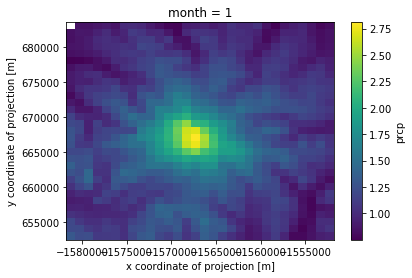

In [31]:
prcp_monthly_mean_ft.loc[1].plot()

The `prcp_monthly_mean_ft` DataArray we created above is grouped by month. Months are on the 0 axis, which ranges from 1 to 12.

In [32]:
prcp_monthly_mean_ft['month']

<xarray.DataArray 'month' (month: 12)>
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

### compare January and August

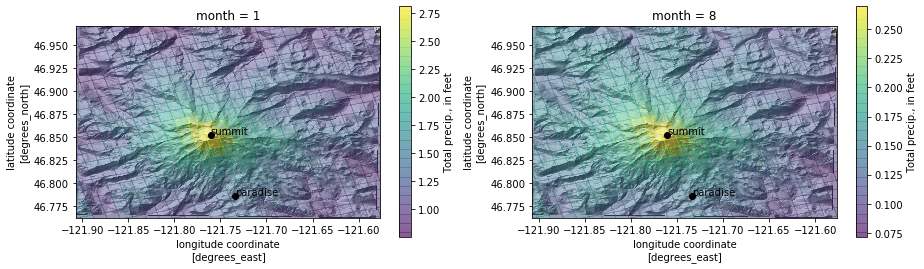

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8.5))
months = [1, 8]

for i, ax in enumerate(axes.flat):
    month = months[i]
    ax.imshow(ls.hillshade(elevations, vert_exag=0.1), cmap='gray', extent=elev_extent, 
              zorder=-1)
    qm = prcp_monthly_mean_ft.loc[month].plot.pcolormesh('lon', 'lat', rasterized=True, #linewidth=0, 
                                                  alpha=0.4, ax=ax,
                                                    cbar_kwargs={"shrink": 0.5, 
                                                                 "label": "Total precip., in feet"}
                                                    )
    ax.set_ylim(*elev_extent[2:])
    ax.set_xlim(*elev_extent[:2])
    for label, (y, x) in coords.items():
        ax.scatter(x, y, c='k')
        ax.text(x, y, label, transform=ax.transData)

### what if we just want to get a timeseries of values at each point of interest, in a pandas DataFrame?

#### first make lists of the x and y values, and a corresponding list of site names

In [34]:
sites = ['summit', 'paradise']
x = []
y = []
for key in sites:
    x.append(coords_lcc[key][0])
    y.append(coords_lcc[key][1])
x, y

([-1567320.5383531053, -1567257.8370503802],
 [667030.7252830399, 659751.1451685634])

For each site, make the selection. Drop the indices we don't need, and convert the resulting DataArray to a pandas DataFrame with the `to_dataframe()` method. Append each dataframe to a list and then concatenate them into a single DataFrame (`axis=1` specifies that the DataFrames should be concatenated along the column axis)

In [35]:
dfs = []
for i, site in enumerate(sites):
    df = ds.prcp.sel(x=x[0], 
                     y=y[0],
                     method='nearest').drop(['lat', 'lon', 'x', 'y']).to_dataframe()
    df.columns = [site]
    dfs.append(df)

df = pd.concat(dfs, axis=1)

In [36]:
df.head()

,summit,paradise
time,,
1980-01-01 12:00:00,48.0,48.0
1980-01-02 12:00:00,24.0,24.0
1980-01-03 12:00:00,31.0,31.0
1980-01-04 12:00:00,23.0,23.0
1980-01-05 12:00:00,48.0,48.0
